# Image classifier using pytorch

In [22]:
pip install torchsummary --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
# importing lobraries 
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from PIL import Image

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import models

import warnings
warnings.filterwarnings("ignore")

In [7]:
#loading the dataset
train_dir = "C:/Users/pater/OneDrive/Documents/Code Practice/Deep Learning with Python/NEU Metal Surface Defects Data/train"
test_dir = "C:/Users/pater/OneDrive/Documents/Code Practice/Deep Learning with Python/NEU Metal Surface Defects Data/test"
valid_dir = "C:/Users/pater/OneDrive/Documents/Code Practice/Deep Learning with Python/NEU Metal Surface Defects Data/valid"

print("Path Directory: ", os.listdir("C:/Users/pater/OneDrive/Documents/Code Practice/Deep Learning with Python/NEU Metal Surface Defects Data"))
print("Train Directory:",os.listdir(train_dir))
print("valid Direcory: ", os.listdir(valid_dir))
print("Test Directory: ", os.listdir(test_dir))

CLASS_NAMES = os.listdir(train_dir)

Path Directory:  ['test', 'Thumbs.db', 'train', 'valid']
Train Directory: ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']
valid Direcory:  ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']
Test Directory:  ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']


In [8]:
print("Training Inclusion data:",len(os.listdir(train_dir+'/'+'Inclusion')))
print("Testing Inclusion data:",len(os.listdir(test_dir+'/'+'Inclusion')))
print("Validation Inclusion data:",len(os.listdir(valid_dir+'/'+'Inclusion')))

Training Inclusion data: 276
Testing Inclusion data: 12
Validation Inclusion data: 12


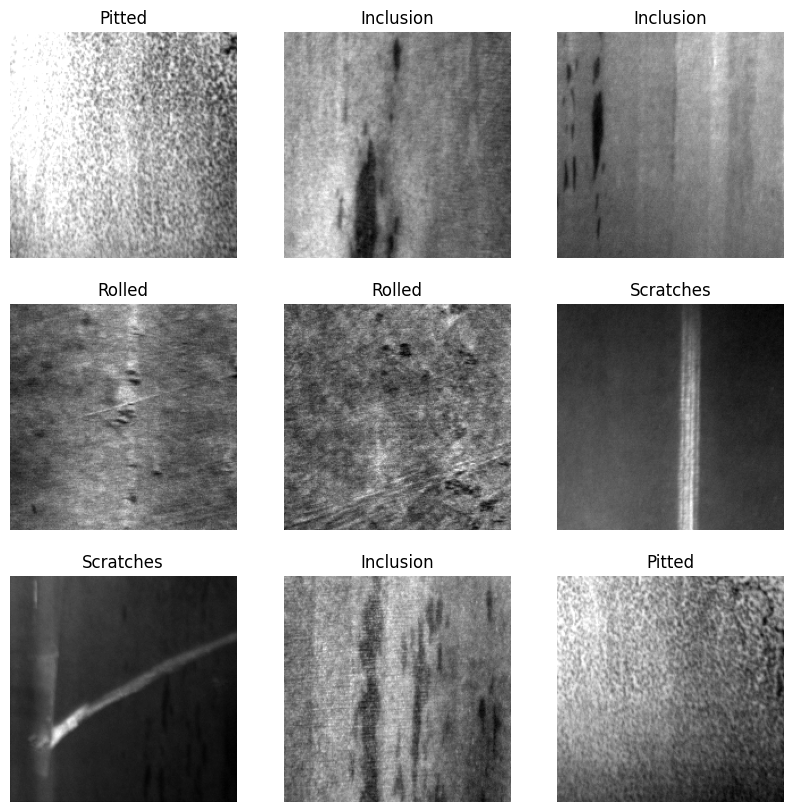

In [9]:
# Function to show random images from training dataset

def show_random_images(data_dir, num_images):
    class_names = os.listdir(data_dir)
    num_rows = int(num_images ** 0.5)
    num_cols = int(num_images ** 0.5)
    fig, axarr = plt.subplots(num_rows, num_cols, figsize=(10,10))
    for i in range(num_rows):
        for j in range(num_cols):
            class_num = random.randint(0, len(class_names)-1)
            img_name = random.choice(os.listdir(os.path.join(data_dir, class_names[class_num])))
            img_path = os.path.join(data_dir, class_names[class_num], img_name)
            img = mpimg.imread(img_path)
            axarr[i, j].imshow(img, cmap = 'gray')
            axarr[i, j].set_title(class_names[class_num])
            axarr[i, j].axis('off')
            
    plt.show()

show_random_images(train_dir, 9)

Image Preprocessing

In [10]:
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        
    ]),
    
    'valid': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

In [11]:
data = {
    'train': datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_dir, transform=image_transforms['valid'])
}

print("Training data: ", len(data['train']))
print("Validation data: ", len(data['valid']))

Training data:  1656
Validation data:  72


In [12]:
BATCH_SIZE = 32
NUM_CLASSES = 6

train_loader = DataLoader(data['train'], batch_size = BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(data['valid'], batch_size = BATCH_SIZE, shuffle=True)

Loading pretrainded model

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [14]:
# Loading Pretrained Weights of Resnet50
model = models.resnet50(pretrained = True).to(device)
summary(model, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\pater/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:17<00:00, 5.85MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Building and Training Model

In [15]:
# Freeze all layers except the last one
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(64, NUM_CLASSES)
)

# Transfer the model to device
model = model.to(device)

In [16]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

In [17]:
num_epochs = 20
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    train_loss = 0
    valid_loss = 0

    # Training loop
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
    
        # Validation loop
    model.eval()
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        valid_loss += loss.item() * images.size(0)
        valid_loss /= len(valid_loader.dataset)
        valid_losses.append(valid_loss)
    
    # Print training and validation loss
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

Epoch [1/20], Train Loss: 0.0261, Valid Loss: 0.2091
Epoch [2/20], Train Loss: 0.0261, Valid Loss: 0.2077
Epoch [3/20], Train Loss: 0.0257, Valid Loss: 0.2064
Epoch [4/20], Train Loss: 0.0255, Valid Loss: 0.2064
Epoch [5/20], Train Loss: 0.0250, Valid Loss: 0.1999
Epoch [6/20], Train Loss: 0.0246, Valid Loss: 0.1990
Epoch [7/20], Train Loss: 0.0234, Valid Loss: 0.1903
Epoch [8/20], Train Loss: 0.0235, Valid Loss: 0.1766
Epoch [9/20], Train Loss: 0.0215, Valid Loss: 0.1577
Epoch [10/20], Train Loss: 0.0214, Valid Loss: 0.1366
Epoch [11/20], Train Loss: 0.0195, Valid Loss: 0.1256
Epoch [12/20], Train Loss: 0.0166, Valid Loss: 0.1124
Epoch [13/20], Train Loss: 0.0138, Valid Loss: 0.0879
Epoch [14/20], Train Loss: 0.0156, Valid Loss: 0.0650
Epoch [15/20], Train Loss: 0.0099, Valid Loss: 0.0698
Epoch [16/20], Train Loss: 0.0097, Valid Loss: 0.0496
Epoch [17/20], Train Loss: 0.0119, Valid Loss: 0.0528
Epoch [18/20], Train Loss: 0.0074, Valid Loss: 0.0507
Epoch [19/20], Train Loss: 0.0094, Va

In [20]:
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)


model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the test images: 86.11111111111111 %


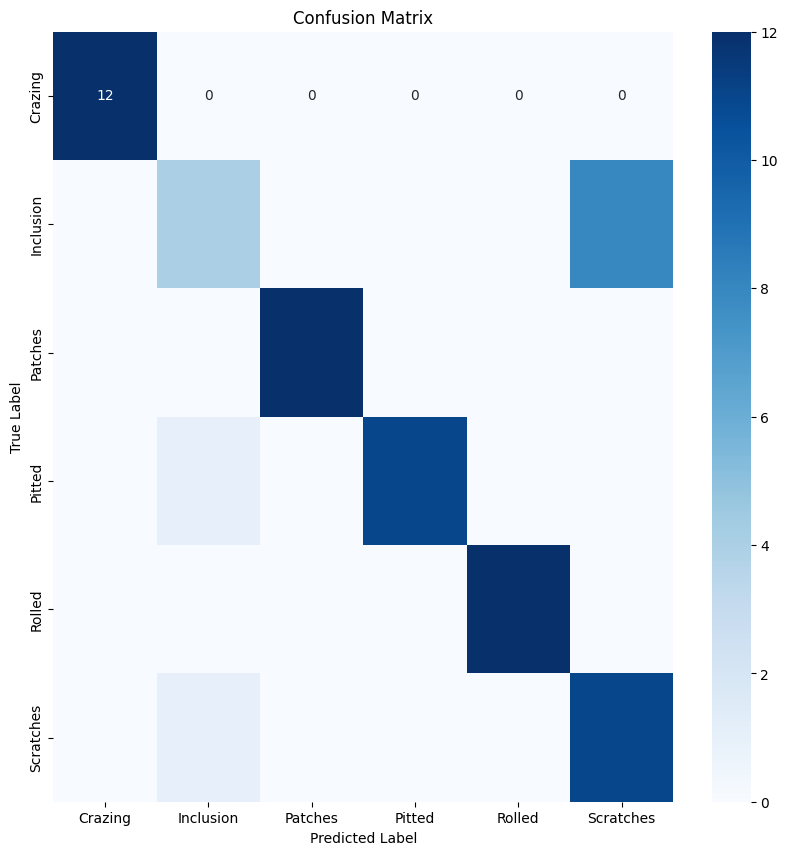

              precision    recall  f1-score   support

     Crazing       1.00      1.00      1.00        12
   Inclusion       0.67      0.33      0.44        12
     Patches       1.00      1.00      1.00        12
      Pitted       1.00      0.92      0.96        12
      Rolled       1.00      1.00      1.00        12
   Scratches       0.58      0.92      0.71        12

    accuracy                           0.86        72
   macro avg       0.87      0.86      0.85        72
weighted avg       0.87      0.86      0.85        72



In [21]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

    
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))